In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [4]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [12]:
# Info on parsed study names and colors
obs=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated',
            backed='r').obs.copy()
uns=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated',
            backed='r').uns.copy()

Load ambient info

In [6]:
# Gene symbol EID map - needed as ambient genes saved as symbols
eid_map=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genomeAnno_ORGmus_musculus_V103.tsv',
                     index_col=0)
eid_map['EID']=eid_map.index

In [3]:
# Files with ambient info
data=[('Fltp_2y','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'),
      ('Fltp_adult','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'),
      ('Fltp_P16','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/'),
      ('NOD','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE144471/'),
      ('NOD_elimination','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE117770/'),
      ('spikein_drug','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'),
      ('embryo','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE132188/rev7/'),
      ('VSG','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/'),
      ('STZ','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/')]

In [7]:
# Load ambient info
datas=[]
for study,path in data:
    # Read data and keep only samples not mean
    data_sub=pd.read_table(path+'ambient_genes_topN_scores.tsv',index_col=0
                         ).drop('mean_ambient_n_counts',axis=1)
    # Map to EIDs
    eid_map.index=eid_map['gene_symbol_'+study]
    # Subset to genes in eid map (e.g. remove some non-gene features)
    data_sub=data_sub.loc[[g for g in eid_map.index if g in data_sub.index],:]
    data_sub.index=eid_map.loc[data_sub.index,'EID']
    data_sub.columns=[c+':'+study for c in data_sub.columns]
    datas.append(data_sub)
# Only keep genes in all samples    
datas=pd.concat(datas,axis=1,join='inner')

Select top ambient genes (union across samples)

In [8]:
# Select top 5 ambient genes in each sample
genes=set()
for col in datas.columns:
    genes.update(datas.sort_values(col,ascending=False,na_position='last').head(3).index)

Plot ambient score (how much gene contributes to ambience) of each gene across samples

In [9]:
# Make sure that all genes have ambient scores across samples
if any(datas.loc[genes,:].isna().any(axis=1)):
    raise ValueError('Some ambient scores are 0')

In [18]:
# Data for plotting
data_plot=pd.DataFrame(datas.loc[genes,:].stack()
                      ).reset_index().rename({'level_1':'col',0:'ambient proportion'},axis=1)
study_map=dict(zip(obs['study'],obs['study_parsed']))
data_plot['study']=pd.Categorical(
    values=[study_map[c.split(':')[1]] for c in data_plot['col']],
    categories=uns['study_parsed_order'],ordered=True)
eid_map.index=eid_map['EID']
data_plot['gene']=[eid_map.at[e,'Gene name'] for e in data_plot['EID']]
# Cmap study
cmap_study=dict(zip(uns['study_parsed_order'],uns['study_parsed_colors']))

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 64.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warn

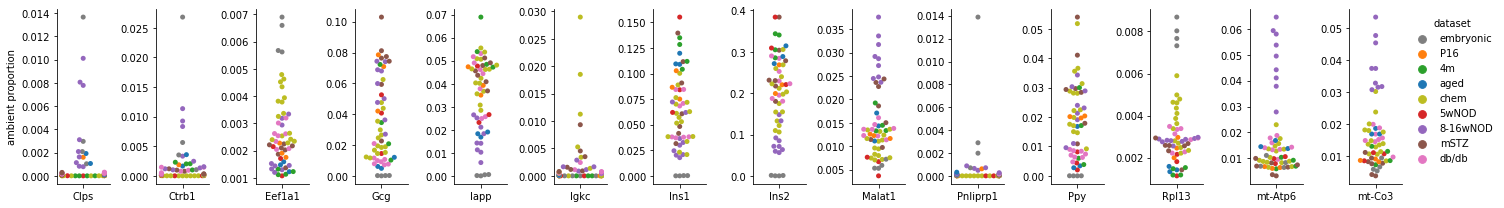

In [14]:
# Plot ambient scores across samples for each gene and color by study
fig,axs=plt.subplots(1,data_plot['gene'].nunique(),figsize=(1.5*data_plot['gene'].nunique(),3))
for i,gene in enumerate(sorted(list(data_plot['gene'].unique()))):
    ax=axs[i]
    sb.swarmplot(x='gene',y='ambient proportion',hue='study',
                 data=data_plot.query('gene==@gene'),ax=ax,s=5,palette=cmap_study)
    if i!=len(axs)-1:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.01,1.), frameon=False,title='dataset')
    if i!=0:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.savefig(path_fig+'swarmplot_atlas_ambientratio.png',
            dpi=300,bbox_inches='tight')